# MODELADO

Esto calcula parametros del potencial PHS para ajustar su coeficiente de virial hasta concidir con el de HS

In [9]:
import numpy as np
from scipy.integrate import quad
import math
import emcee
import corner
import matplotlib.pyplot as plt
import getdist
import IPython
from getdist import plots, MCSamples

In [56]:
np.random.seed(42)
D = 4
V = lambda r: np.pi**(D/2) * r**D / math.gamma(D/2 + 1) 
integrand = lambda r: r**(D - 1)
result, error = quad(integrand, 0, 1)
B_HS = result * np.pi**(D / 2) / math.gamma(D / 2)

def log_likelihood(theta):
    r, a, T = theta
    e = 1 / T

    
    A = r / (r - a) * (r / a)**(a / (r - a))
    B = (r / a)**(1 / (r - a))
        
    def u(x):
        if x >= B:
            return 0
        return A * e * ( (1/x)**r - (1/x)**a ) + e
    
    integrand = lambda r: (np.exp(-u(r)) - 1) * r**(D-1)
    result, error = quad(integrand, 0, B)
    B_PHS = -result * np.pi**(D / 2) / math.gamma(D / 2)
    chi =  np.sum((B_HS - B_PHS)**2)
    return -0.5 * np.log10(chi)

def log_prior(theta):
    r, a, T = theta
    if 55 < a < 76 and < r < 75 and 0 < T < 6:
        return 0.0 
    return -np.inf

def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

ndim = 3          
nwalkers = 30
p0_r = np.random.normal(65, np.sqrt(5), nwalkers)
p0_a = np.random.normal(60, np.sqrt(5), nwalkers)
p0_T = np.random.normal(3, np.sqrt(2), nwalkers)
p0 = np.column_stack([p0_r, p0_a, p0_T])
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(p0, 10000, progress=True)
samples = sampler.get_chain(discard=2000, flat=True)

corner.corner(samples, labels=["\lambda_r", "\lambda_a", "T"])
plt.show()

 18%|████████                                     | 1803/10000 [00:17<01:18, 103.81it/s]Traceback (most recent call last):
  File "/home/alan/cetera/lab/lib/python3.11/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_25251/2864069861.py", line 37, in log_posterior
    return lp + log_likelihood(theta)
                ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_25251/2864069861.py", line 22, in log_likelihood
    result, error = quad(integrand, 0, B)
                    ^^^^^^^^^^^^^^^^^^^^^
  File "/home/alan/cetera/lab/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py", line 459, in quad
    retval = _quad(func, a, b, args, full_output, epsabs, epsrel, limit,
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/alan/cetera/lab/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py", line 606, in _quad
    retu

emcee: Exception while calling your likelihood function:
  params: [65.29980137 66.09810066  1.58063909]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

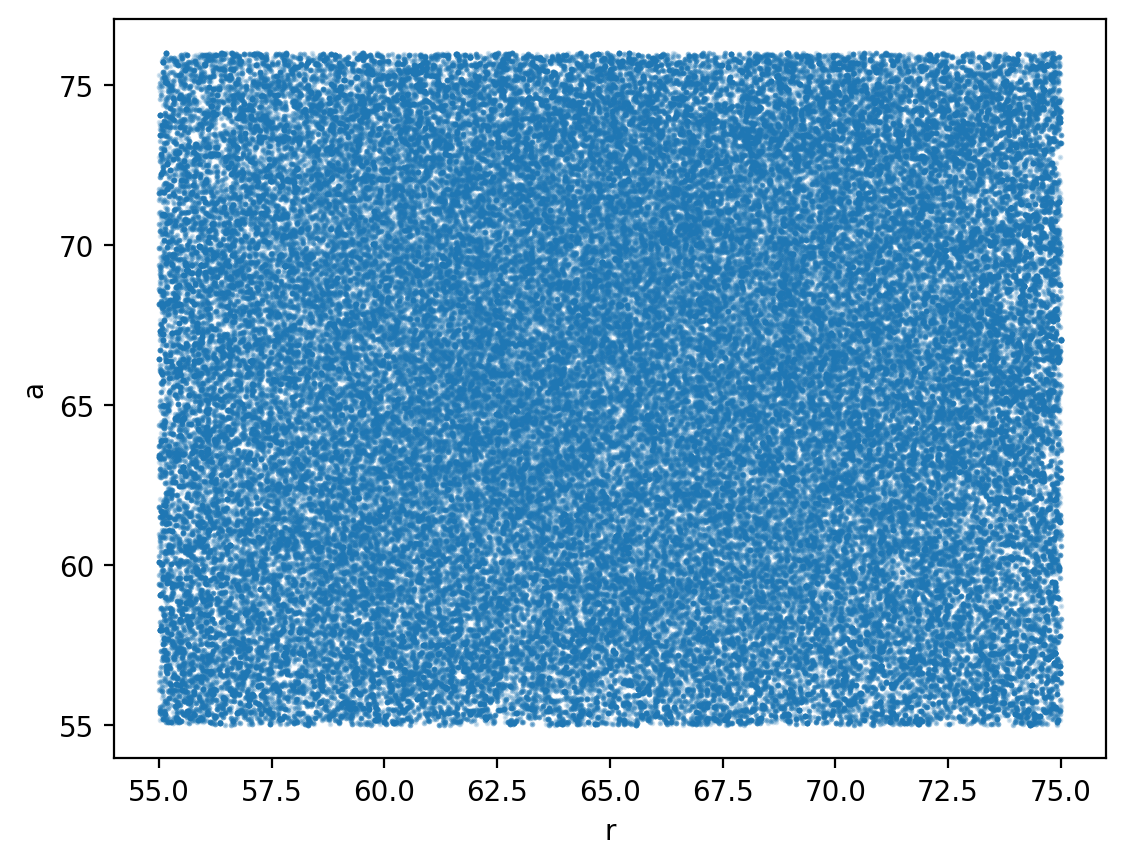

In [52]:
plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.2)
plt.xlabel("r")
plt.ylabel("a")
plt.show()

In [53]:
param_names = [r'$\lambda_r$', r'$\lambda_a$', r'$T$']
mcsamples = MCSamples(samples = samples, names = param_names)
s = mcsamples.copy(settings={'mult_bias_correction_order':1,
                       #'smooth_scale_2D':0, 
                       'smooth_scale_1D':0.8})

Removed no burn in


In [54]:
mcsamples.getMeans()

array([65.08575561, 65.73975835,  2.61034783])

<Figure size 1500x1500 with 0 Axes>

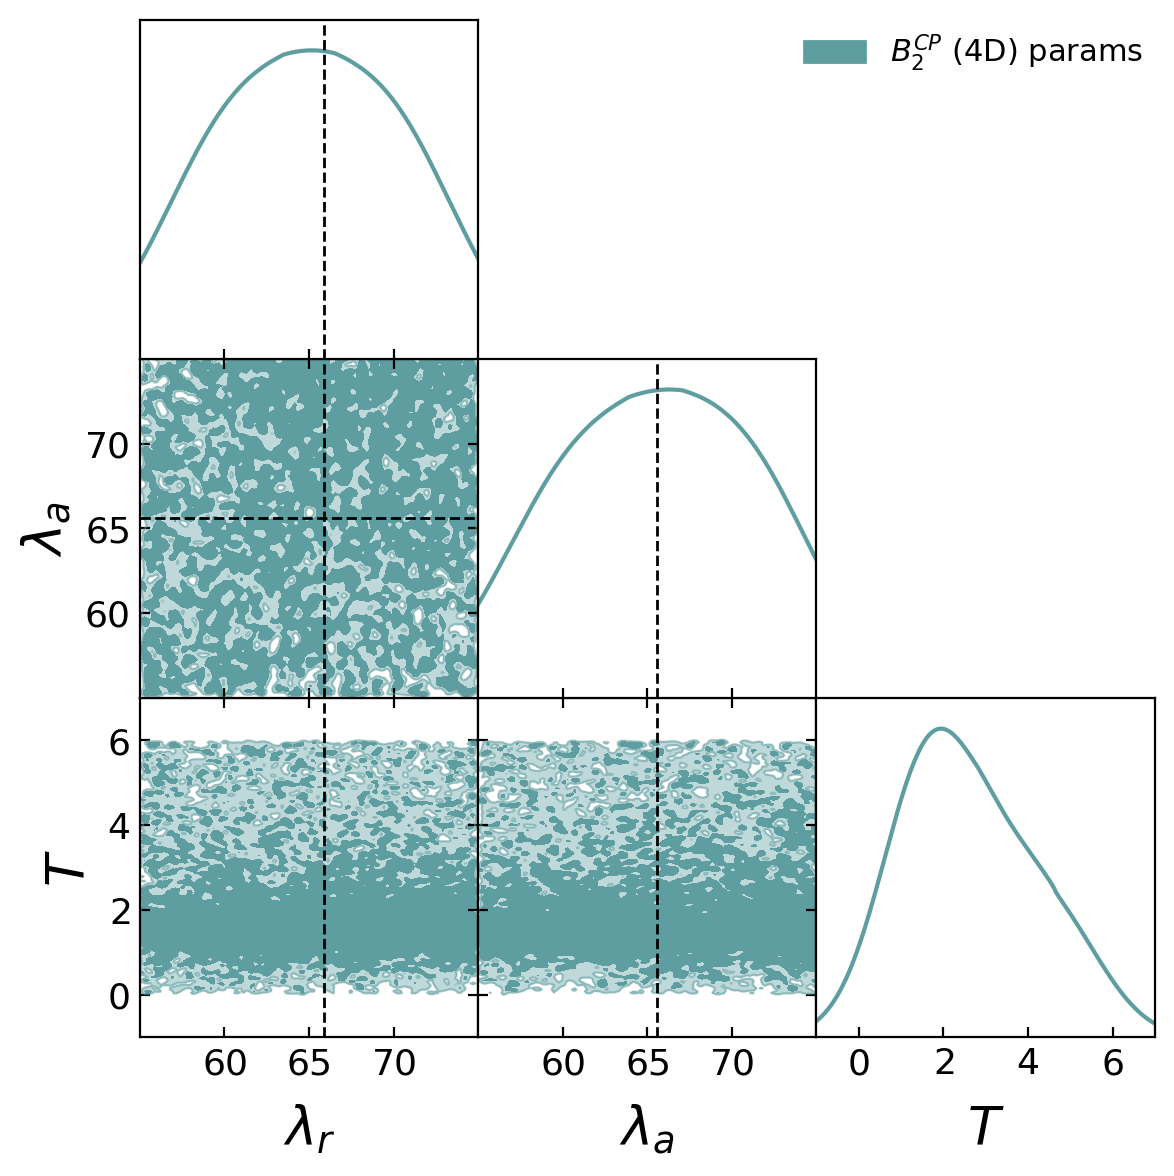

In [55]:



%matplotlib inline
%config InlineBackend.figure_format = 'retina'

g = plots.get_subplot_plotter()
g.fig = plt.figure(figsize=(15, 15))
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.8  # Transparency for filled contours
#g.settings.linewidth = 1.5  # Width of contour lines
g.settings.axis_marker_color = 'k'
g.settings.legend_fontsize =  14#16 #18
g.settings.axes_labelsize = 22  #22
g.settings.axes_fontsize = 16 #16
g.settings.axis_marker_lw = 1


g.triangle_plot([s], filled=[True, True, True, True],
               contour_colors=['cadetblue'],figure_kwargs={"figsize": (15,15)},
                contour_lws = [1.5, 1.5, 1.5], contour_ls = ['-','-'],marker_args = ({'color':'k','lw' :  1}),
                #params = params,
               markers = [65.90, 65.60],
                #title_limit=0,
                legend_labels = [r'$B_2^{CP}$ (4D) params'],
                param_limits={r'$\lambda_r$':[55,75],r'$\lambda_a$':[55,75]}
                ,legend_loc = 'upper right')

#plt.suptitle(r'cosmo1 fits')
plt.savefig('lambda_a-lambda_r-phs_potential-4d', dpi=300, bbox_inches='tight')